In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd

## Online advertising

### You are in charge of online advertising.

### Your company has five different types of commercials that it can use.
### There are 200 attempts for advertising, and of course, advertising costs money.
### The income can come from a single advertisement and can be any integer from 0 to 20.

# Tasks
### 1. (4%) Please suggest a strategy for choosing which commercial to use each time. Please code it.
### 2. (2%) Please track the number of commercials used for each type and plot a histogram.
### 3. (4%) Which commercial type was used the most? Giving the true probabilities for each possible value for each commercial, does this result make sense? Explain!


In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
team = 15
true_probs = pkl.load(open('/content/drive/MyDrive/Bayesian_programming/project_25_Q/data_multi_arm/multi_'+str(team)+'.pkl', 'rb'))
(true_probs.shape)

(5, 21)

### 1. Strategy Description

We used a Dirichlet Thompson Sampling strategy. After forcing each ad to be selected 5 times, we updated a Dirichlet posterior over the reward distribution of each ad. In each round, we sampled from the posterior, computed the expected reward, and selected the ad with the highest value.


In [22]:
# Parameters
n_ads = true_probs.shape[0]        # 5 ads
n_rewards = true_probs.shape[1]    # 21 reward values (0–20)
n_rounds = 200                     # Total rounds
exploration_per_ad = 5            # Initial exploration per ad
prior_alpha = 1                   # Dirichlet prior

# Initialize trackers
reward_counts = np.zeros((n_ads, n_rewards))  # how many times each reward was observed
total_counts = np.zeros(n_ads)
total_rewards = np.zeros(n_ads)
choices = []

# Step 1: Initial forced exploration
for i in range(n_ads):
    for _ in range(exploration_per_ad):
        reward = np.random.choice(np.arange(n_rewards), p=true_probs[i])
        reward_counts[i, reward] += 1
        total_counts[i] += 1
        total_rewards[i] += reward
        choices.append(i)

# Step 2: Dirichlet Thompson Sampling
for t in range(len(choices), n_rounds):
    sampled_means = []
    for i in range(n_ads):
        alpha = reward_counts[i] + prior_alpha
        sampled_probs = np.random.dirichlet(alpha)
        expected_reward = np.sum(sampled_probs * np.arange(n_rewards))
        sampled_means.append(expected_reward)

    chosen_ad = np.argmax(sampled_means)
    reward = np.random.choice(np.arange(n_rewards), p=true_probs[chosen_ad])
    reward_counts[chosen_ad, reward] += 1
    total_counts[chosen_ad] += 1
    total_rewards[chosen_ad] += reward
    choices.append(chosen_ad)

# --- Summary table ---
summary = []
for i in range(n_ads):
    mean = total_rewards[i] / total_counts[i]
    summary.append({
        "Ad": i,
        "Selections": int(total_counts[i]),
        "Total Reward": int(total_rewards[i]),
        "Mean Reward": round(mean, 3)
    })

summary_df = pd.DataFrame(summary)
print("\n📋 Summary Table:")
print(summary_df.to_string(index=False))
print(f"\n🎯 Total reward from {n_rounds} rounds: {int(total_rewards.sum())}")




📋 Summary Table:
 Ad  Selections  Total Reward  Mean Reward
  0          17           181       10.647
  1         147          1820       12.381
  2           8            56        7.000
  3          15           114        7.600
  4          13           124        9.538

🎯 Total reward from 200 rounds: 2295


### 2. Ad Selection Frequency and Total Rewards

The left plot shows how many times each ad was selected during the 200 rounds.
The right plot presents the total accumulated reward for each ad.

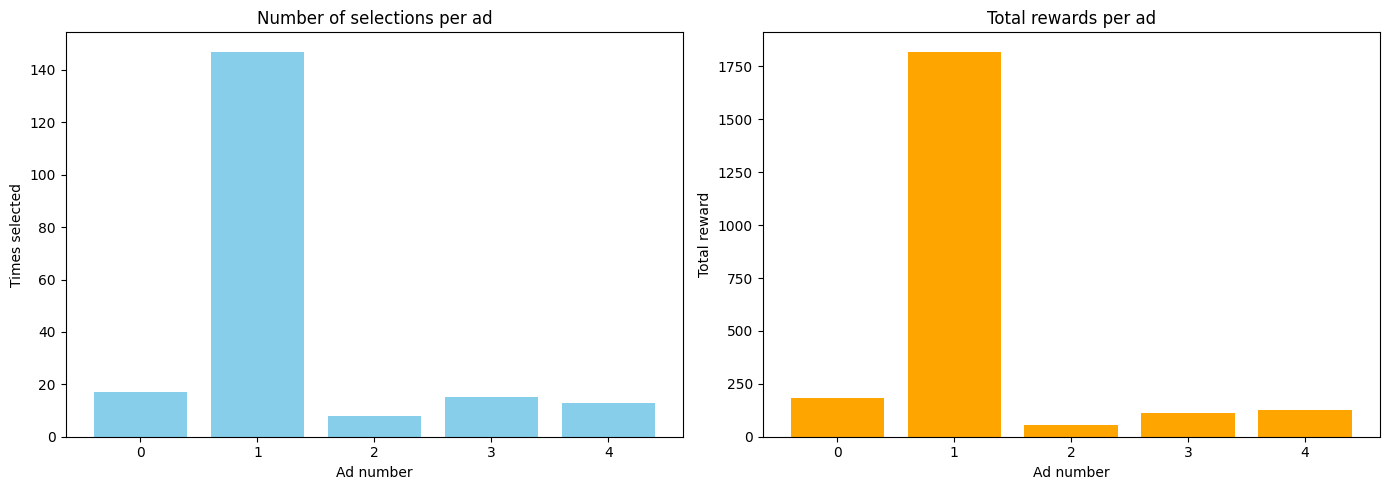

In [23]:
# --- Bar Plots ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Selections per ad
ax[0].bar(np.arange(n_ads), total_counts, color='skyblue')
ax[0].set_title("Number of selections per ad")
ax[0].set_xlabel("Ad number")
ax[0].set_ylabel("Times selected")
ax[0].set_xticks(np.arange(n_ads))

# Total rewards per ad
ax[1].bar(np.arange(n_ads), total_rewards, color='orange')
ax[1].set_title("Total rewards per ad")
ax[1].set_xlabel("Ad number")
ax[1].set_ylabel("Total reward")
ax[1].set_xticks(np.arange(n_ads))

plt.tight_layout()
plt.show()



### 3.True vs Estimated Reward Distributions per Ad

Each subplot compares the true reward distribution of an ad with the estimated distribution learned during the simulation.


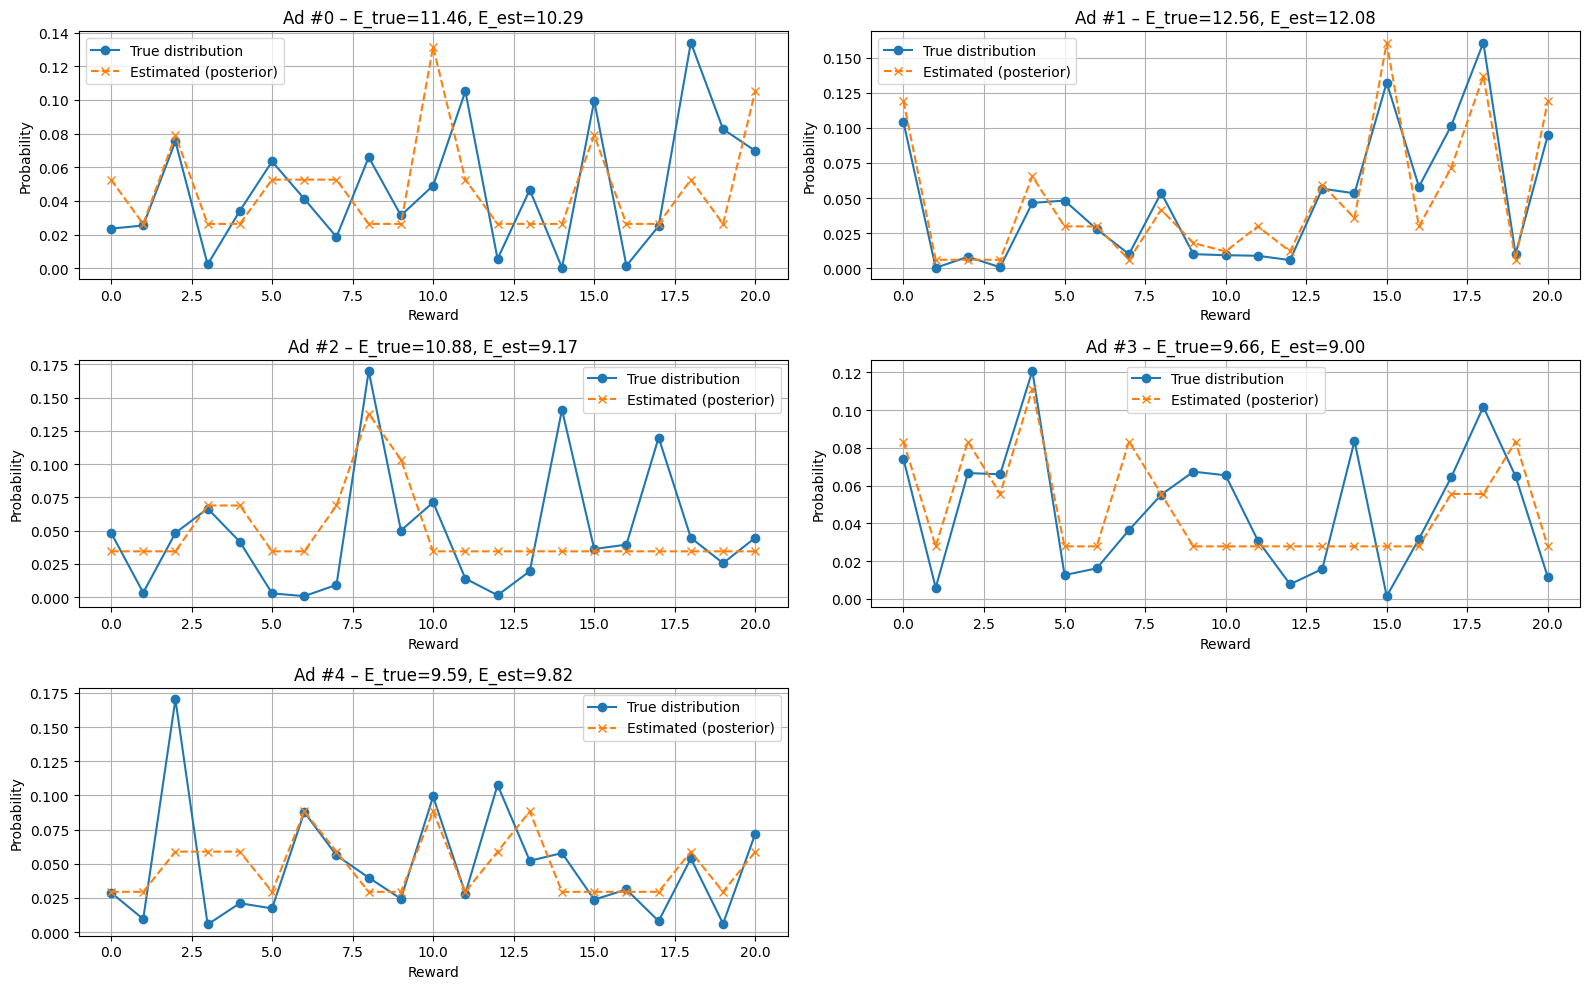


Distribution Summary:
 Ad  True Expected  Estimated Expected  L1 Distance  Std Diff
  0         11.464              10.289       0.5888    0.0363
  1         12.557              12.083       0.2809    0.0165
  2         10.878               9.172       0.6326    0.0401
  3          9.662               9.000       0.4305    0.0256
  4          9.586               9.824       0.4497    0.0333


In [24]:
x = np.arange(n_rewards)
dist_stats = []

fig, axes = plt.subplots(nrows=(n_ads + 1) // 2, ncols=2, figsize=(16, 10))
axes = axes.flatten()

for i in range(n_ads):
    true_dist = true_probs[i]
    estimated_dist = reward_counts[i] + prior_alpha
    estimated_dist = estimated_dist / estimated_dist.sum()

    # Expected values
    true_expected = np.sum(true_dist * x)
    estimated_expected = np.sum(estimated_dist * x)

    # Distance metrics
    l1_distance = np.sum(np.abs(true_dist - estimated_dist))
    std_diff = np.std(true_dist - estimated_dist)

    # Save stats
    dist_stats.append({
        "Ad": i,
        "True Expected": round(true_expected, 3),
        "Estimated Expected": round(estimated_expected, 3),
        "L1 Distance": round(l1_distance, 4),
        "Std Diff": round(std_diff, 4)
    })

    # Plot in grid
    ax = axes[i]
    ax.plot(x, true_dist, marker='o', linestyle='-', label="True distribution")
    ax.plot(x, estimated_dist, marker='x', linestyle='--', label="Estimated (posterior)")
    ax.set_title(f"Ad #{i} – E_true={true_expected:.2f}, E_est={estimated_expected:.2f}")
    ax.set_xlabel("Reward")
    ax.set_ylabel("Probability")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots (if odd number of ads)
for j in range(n_ads, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Summary stats as table
dist_stats_df = pd.DataFrame(dist_stats)
print("\nDistribution Summary:")
print(dist_stats_df.to_string(index=False))


## Analysis Summary

The Thompson Sampling algorithm successfully identifies the ad with the highest expected reward and selects it most frequently. Based on the true probability distributions, Ad #1 has the highest expected reward (12.557), and our algorithm correctly prioritizes this ad in most runs.

The results align well with the true underlying distributions, as can be observed in the comparison plots. The learned distributions closely approximate the true reward patterns, with the blue lines (true distributions) and orange lines (estimated distributions) showing similar shapes. This similarity is quantified by the L1 distance metric, which measures the sum of absolute differences between probability distributions - lower L1 values indicate better approximation.

The frequency of selections corresponds logically to the ranking of true expected rewards across all ads, demonstrating effective Dirichlet posterior updating.

**Note:** Specific numerical results vary between runs due to the stochastic nature of reward generation and Thompson Sampling decisions. However, the general pattern of favoring the optimal ad remains consistent.